In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# 目标
- 用模板匹配查找目标。
- 涉及以下函数：**cv2.matchTemplate()**，**cv2.minMaxLoc()**。

# 1. 理论
模板匹配是一种在大图像中查找和搜索模板图像位置的方法。OpenCV提供了**cv2.matchTemplate()**函数实现此目的。它简单的在输入图像上滑动模板图像（类似于2D卷积），然后比较模板和输入图像中对应的图像块。OpenCV提供了几种不同的比较方法（可以阅读文档获得更详细的信息）。该函数返回一幅灰度图像，像素的值表示该像素的邻域与模板之间的匹配程度。

如果输入图像的尺寸为$W \times H$，模板图像尺寸为$w \times h$，则输出图像的尺寸为$(W-w+1) \times (H-h+1)$。在得到该结果后，可以使用**cv2.minMaxLoc()**函数找到最大和最小值。用其坐标作为矩形的左上角，$(w, h)$作为矩形的宽度和高度，该矩形就是模板区域。

> **注意**  
> 如果使用**cv2.TM_SQDIFF**作为相似性度量方法，最小值是最佳匹配。

# 2. 用OpenCV进行模板匹配
在下面的例子中，要在图像中找到梅西的脸，因此首先创建模板如下：![](./imgs/messi_face.jpg)
下面的例子展示了不同相似性度量方法的结果：

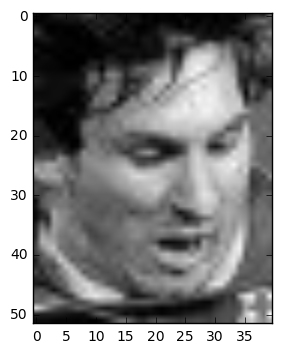

In [2]:
img = cv2.imread('../data/messi5.jpg', cv2.IMREAD_GRAYSCALE)
template = cv2.imread('../data/template.jpg', cv2.IMREAD_GRAYSCALE)

w, h = template.shape[::-1]
plt.imshow(template, 'gray')

In [3]:
def templateMatch(source, template, method):
    img = source.copy()
    res = cv2.matchTemplate(img, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    cv2.rectangle(img, top_left, bottom_right, 255, 2)
    
    plt.subplot(121), plt.imshow(res, cmap='gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(122), plt.imshow(img, cmap='gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        

- cv2.TM_SQDIFF的相似性度量公式
$$R(x,y)=\sum_{x',y'}(T(x',y')-I(x+x',y+y'))^2$$

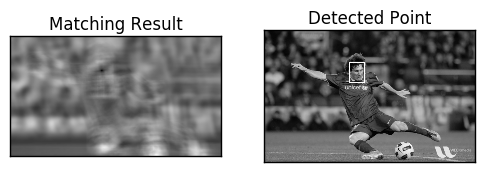

In [4]:
templateMatch(img, template, cv2.TM_SQDIFF)

- cv2.TM_SQDIFF_NORMED的相似性度量公式
$$R(x,y)=\frac {\sum_{x',y'}(T(x',y')-I(x+x',y+y'))^2} {\sqrt {\sum_{x',y'}T(x', y')^2 \cdot \sum_{x', y'}I(x+x',y+y')^2}}$$

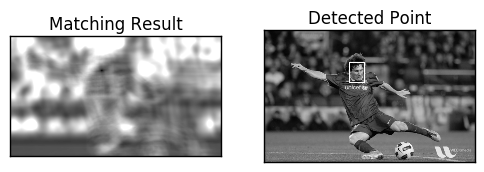

In [5]:
templateMatch(img, template, cv2.TM_SQDIFF_NORMED)

- cv2.TM_CCORR的相似性度量公式
$$R(x,y)=\sum_{x',y'}(T(x',y') \cdot I(x+x',y+y'))$$

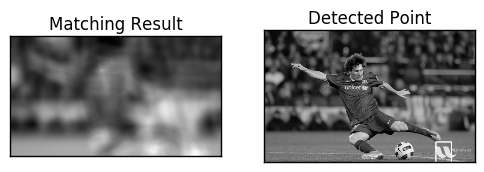

In [6]:
templateMatch(img, template, cv2.TM_CCORR)

- cv2.TM_CCORR_NORMED的相似性度量公式
$$R(x,y)=\frac {\sum_{x',y'}(T(x',y') \cdot I(x+x',y+y'))} {\sqrt {\sum_{x',y'}T(x', y')^2 \cdot \sum_{x', y'}I(x+x',y+y')^2}}$$

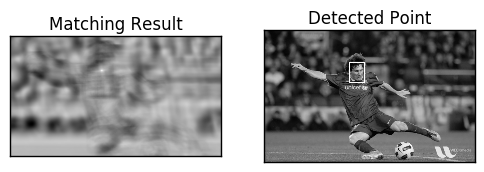

In [7]:
templateMatch(img, template, cv2.TM_CCORR_NORMED)

- cv2.TM_CCOEFF的相似性度量公式
$$R(x,y)=\sum_{x',y'}(T'(x',y') \cdot I'(x+x',y+y'))^2$$
其中
$$T'(x',y')=T(x',y') - \frac 1 {w \cdot h} \cdot \sum_{x'', y''}T(x'',y'')$$
$$I'(x+x',y+y')=I(x+x',y+y') - \frac 1 {w \cdot h} \cdot \sum_{x'',y''}I(x+x'',y+y'')$$

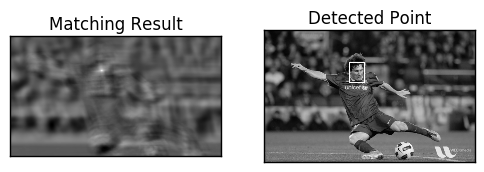

In [8]:
templateMatch(img, template, cv2.TM_CCOEFF)

- cv2.TM_CCOEFF_NORMED的相似性度量公式
$$R(x,y)=\frac {\sum_{x',y'}(T'(x',y') \cdot I'(x+x',y+y'))^2} {\sqrt {\sum_{x',y'}T'(x',y')^2 \cdot \sum_{x',y'}I'(x+x',y+y')^2 }}$$

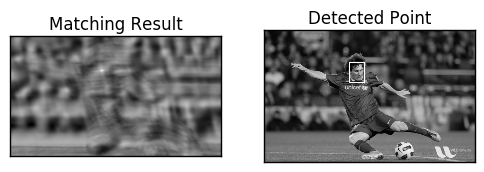

In [9]:
templateMatch(img, template, cv2.TM_CCOEFF_NORMED)

从上面的结果中可以看到**cv2.TM_CCORR**的结果与预期结果不一致。

# 3. 多目标模板匹配
前面的例子中，模板在源图像中只出现了一次。假设搜索的目标出现了多次，这种情况下**cv2.minMaxLoc()**就无法得到所有的位置。在这种情况下需要使用阈值，下面的例子中，将使用超级玛丽的截屏进行多目标搜索。

(<matplotlib.axes._subplots.AxesSubplot at 0x1168602e8>,
 <matplotlib.image.AxesImage at 0x11aa86f60>)

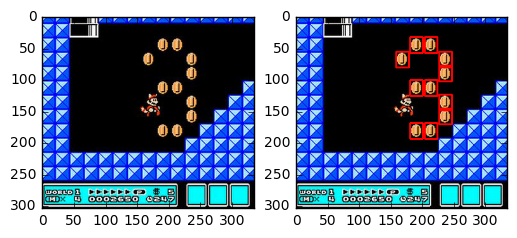

In [10]:
img_rgb = cv2.imread('../data/mario.jpg')
img_source = img_rgb.copy()
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('../data/mario_template.jpg', cv2.IMREAD_GRAYSCALE)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
threshold = 0.95
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
    
plt.subplot(121), plt.imshow(img_source[:,:,::-1])
plt.subplot(122), plt.imshow(img_rgb[:, :, ::-1])